# House Prices prediction

# Part 2. Feature Engineering
**Process**
 + StandardScaler to skewed variables
 + Onehotencoding to categorical variables
 + delete redundant variables

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

### Warning: before we start..
In last section, I conducted EDA only on train set! It's still not a big deal since EDA result is just for insight. BUT, BEFORE WE START MODELING, WE HAVE TO COMBINE TRAIN AND TEST SETS AND THEN CONDUCT FEATRUE ENGINEERING. Why? It's due to **categorical variables**. Generally we have to apply `pd.get_dummies` function to one-hot encode categorical variables. Sometimes, train and test sets have different number of categories in specific variable, so resulting number of columns after applying `pd.get_dummies` can be different. To prevent this, let's start with combining train and test sets and then do feature engineering on combined dataset!

In [2]:
# load preprocessed dataset in EDA
train = pd.read_csv('train.csv',header=0)
test = pd.read_csv('test.csv',header=0)
print('Train set: ',train.shape)
print('Test set: ',test.shape)

Train set:  (1460, 81)
Test set:  (1459, 80)


In [3]:
# combine train and test set
df = pd.concat([train,test])

# test set preprocessing(from EDA)
df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1,inplace=True)
df = df.dropna(subset=['GarageYrBlt','BsmtExposure','BsmtFinType2'])
df['MasVnrArea'].fillna(df['MasVnrArea'].mean(),inplace=True)
df = df.dropna(subset=['Electrical','MasVnrType'])
df['LotFrontage'].fillna(method='ffill',inplace=True)

print(df.shape)

(2667, 75)


Check if there is any NA value left. Those columns are all categorical variables, and NA values are not any of category so we have to delete those missing values.

In [4]:
df.isnull().sum().sort_values(ascending=False)[:10]

SalePrice      1329
BsmtCond          3
BsmtQual          2
MSZoning          1
KitchenQual       1
SaleType          1
Utilities         1
Functional        1
MasVnrArea        0
RoofMatl          0
dtype: int64

In [5]:
# drop unnecessary ID variable 
df.dropna(subset=['BsmtCond','BsmtQual','MSZoning','KitchenQual','SaleType','Utilities','Functional'],inplace=True)

### (1) Check skewed float variables

When we conduct regression prediction, it's really important to scale your data. Results from regression are highly affected by values of each variable. One of the methods to test normality is to measure **skewness**. In this section, we are going to log-transform variables whose skewness is greater than 2.<br>

Related information link:
<https://help.gooddata.com/doc/en/reporting-and-dashboards/maql-analytical-query-language/maql-expression-reference/aggregation-functions/statistical-functions/predictive-statistical-use-cases/normality-testing-skewness-and-kurtosis>

In [6]:
# find variables with skewness more than 1
skewness = pd.DataFrame()
skewness['variable'] = df.select_dtypes(exclude='object').columns
skewness['skew']= skew(df.select_dtypes(exclude='object'))
skewness_big = skewness[skewness['skew']>2]
skewness_big

,variable,skew
2,LotArea,13.171998
7,MasVnrArea,2.501055
9,BsmtFinSF2,3.999000
14,LowQualFinSF,14.130985
17,BsmtHalfBath,3.725111
21,KitchenAbvGr,5.691106
28,OpenPorchSF,2.235935
29,EnclosedPorch,4.256459
30,3SsnPorch,11.188466
31,ScreenPorch,3.810586


In [7]:
# log transfrom variables
df[skewness_big['variable']] = np.log1p(df[skewness_big['variable']])
df[skewness_big['variable']]

,LotArea,MasVnrArea,BsmtFinSF2,LowQualFinSF,BsmtHalfBath,KitchenAbvGr,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,9.042040,5.283204,0.000000,0.0,0.000000,0.693147,4.127134,0.000000,0.0,0.0,0.0,0.0
1,9.169623,0.000000,0.000000,0.0,0.693147,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0
2,9.328212,5.093750,0.000000,0.0,0.000000,0.693147,3.761200,0.000000,0.0,0.0,0.0,0.0
3,9.164401,0.000000,0.000000,0.0,0.000000,0.693147,3.583519,5.609472,0.0,0.0,0.0,0.0
4,9.565284,5.860786,0.000000,0.0,0.000000,0.693147,4.442651,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1451,9.501890,5.273000,5.843544,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0
1452,7.335634,0.000000,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0
1455,7.546974,0.000000,0.000000,0.0,0.000000,0.693147,3.218876,0.000000,0.0,0.0,0.0,0.0
1456,9.903538,0.000000,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.0


Choose one of transformed columns and check if it's distribution is less skewed. We can see that after log transformation, distribution plot of those variables are close to normal distribution.

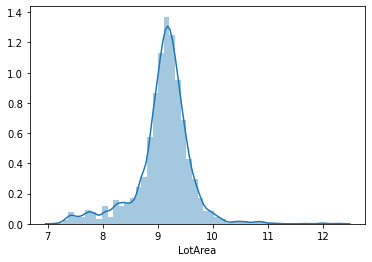

In [9]:
# example of log-transformed variable
sns.distplot(df['LotArea'])

## (2) Remove redundant variables
Now, we have to remove redundant variables since those variables might cause **multicolinearity** problem. Use correlation matrix to get variables to drop - we are going to drop variables whose absolute value of correlation with other variables greater than 0.8.<br>
If you want to know more EDA about this part, here's link: <https://www.kaggle.com/hyewon328/houseprices-eda-with-explanations>

In [10]:
corr_mat = df.corr()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
drop_list = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
print('#### Columns to drop (redundant columns) ####')
print(drop_list) # warning: SalePrice is our target variable, so we should not delete this variable

#### Columns to drop (redundant columns) ####
['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']


In [11]:
df.drop(drop_list,axis=1,inplace=True)
print(df.shape)

(2657, 71)


## (3) Deal with categorical variables
All object type variables are categorical variables. Linear Regression model cannot recognize object values, so we have to **One-hot encode** object variables.

Before we start, let's figure out how many categories each categorical variable has. Most of the categorical variables have less than 10 unique categories. Especially, `Neighborhood` variable denotes regions so it has more than 20 categories. Plust, there are also **numerical type categorical variables**, so let's find those ones first!

**Find numerical type categorical variables** <br>
`MSSubClass`,`OverallQual`,`OverallCond`,`YearBuilt`,`YearRemodAdd`,`MoSold`,`YrSold`

In [30]:
df.select_dtypes(np.int64).head(3)

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,Fireplaces,WoodDeckSF,MoSold,YrSold
0,60,7,5,2003,2003,854,1710,2,1,3,0,0,2,2008
1,20,6,8,1976,1976,0,1262,2,0,3,1,298,5,2007
2,60,7,5,2001,2002,866,1786,2,1,3,1,0,9,2008


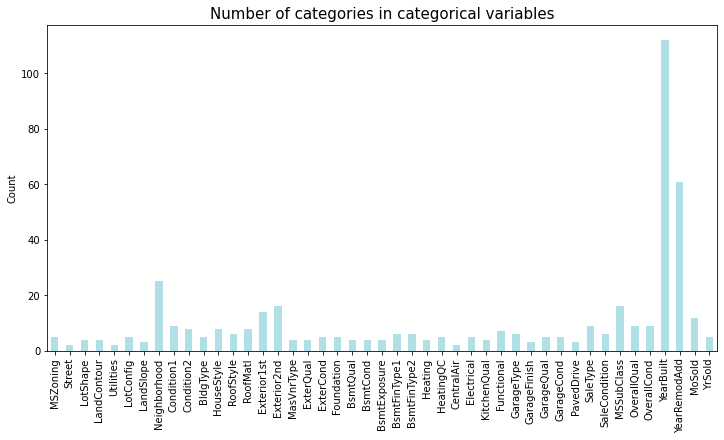

In [44]:
# object category
obj_cat = df.select_dtypes('object').columns.tolist()
# integer category
int_cat = ['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MoSold','YrSold']

plt.figure(figsize=(12,6))
df[obj_cat+int_cat].nunique().plot.bar(color='powderblue')
plt.title('Number of categories in categorical variables',fontsize=15);
plt.ylabel('Count')
plt.show()

**Change numerical categorical values to string** <br>
Before one-hot encoding, we must change numerical categorical values to string type. `pd.get_dummies` function does not recognize numerical values as categorical variables.<br>

In [47]:
for col in int_cat:
    df[col]=str(df[col])
    
df[int_cat].dtypes

MSSubClass      object
OverallQual     object
OverallCond     object
YearBuilt       object
YearRemodAdd    object
MoSold          object
YrSold          object
dtype: object

### LabelEncdoing vs One-hot Encoding
There are two types of encoding strategy - Label Encoding & One-hot Encoding. Let's compare those first. <br>
 + LabelEncoding
  - Ad: Do not produce more columns - less overfitting hazard than one-hot encoding
  - Disad: For linear regression models, numerically encoded values affect result in order (ex: 1<2<3<..)
 + One-hot Encoding
  - Ad: prevents model from recognizing categorical variables in order
  - Disad: Produces too many columns - overfitting problem
  
Therefore, we are going to apply different encoding strategy depending on types of regression models. <br>


|LabelEncoding|One-hot Encoding|
|:-------------:|:-------------:|
|Tree based regression|Simple linear regression|

## Next..
# Part 3: Modeling
Now it's time to construct linear regresson model! I'm going to use several linear regression functions and compare performances. Those are regression model list to try and overall modeling procedure.<br>
<br>
**Regression list**
 + Simple linear regression
 + Ridge regression
 + Random forest regressor
 + LGBM regressor
 
**Modeling procedure**
 1. try 4 inear regression models without hyperparameter tuing
 2. cross validation(KFold)
 3. hyperparameter tuning
 4. feature selection